In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

#Txakur eta katuen datuak deskargatu
datuak, metadatuak = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteQ8QM8B/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


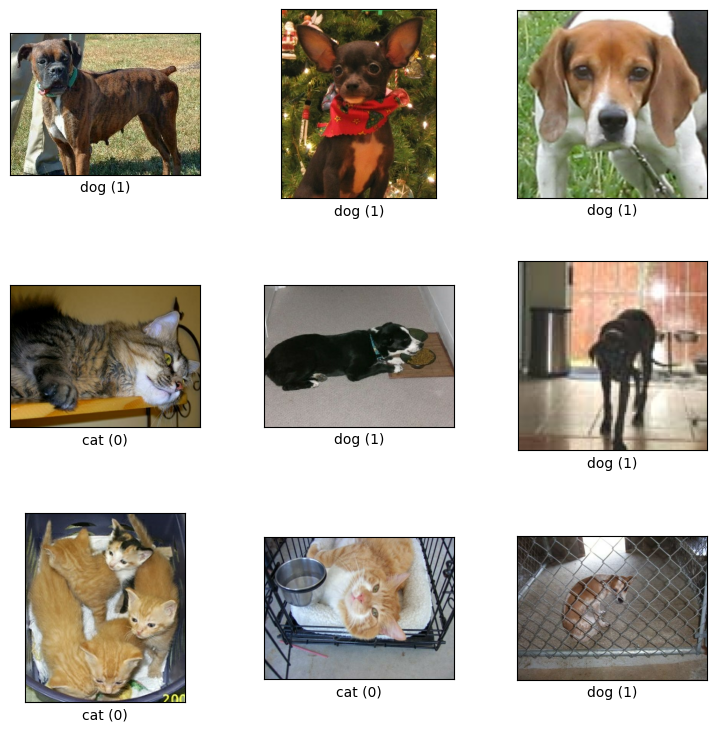

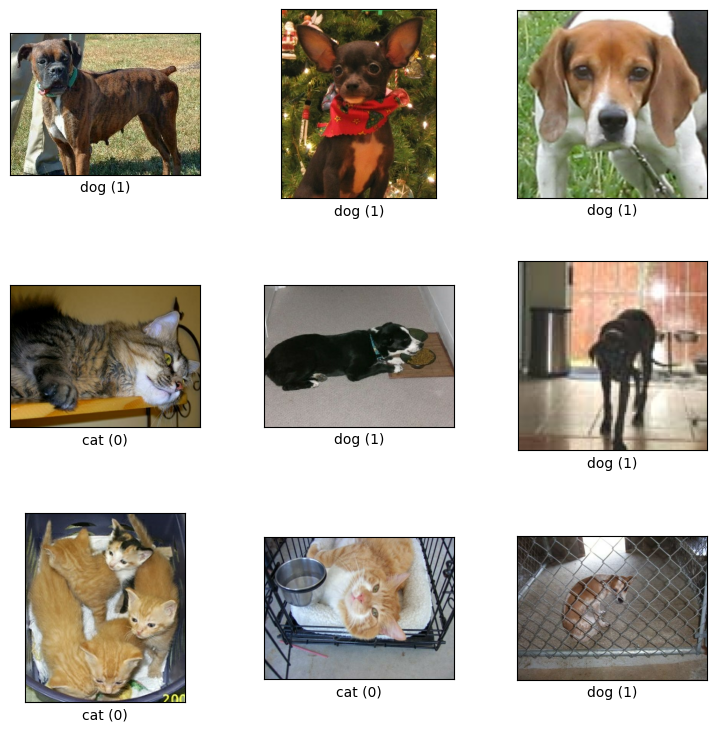

In [ ]:
#Datuen adibide batzuk ikusteko
tfds.show_examples(datuak['train'], metadatuak)

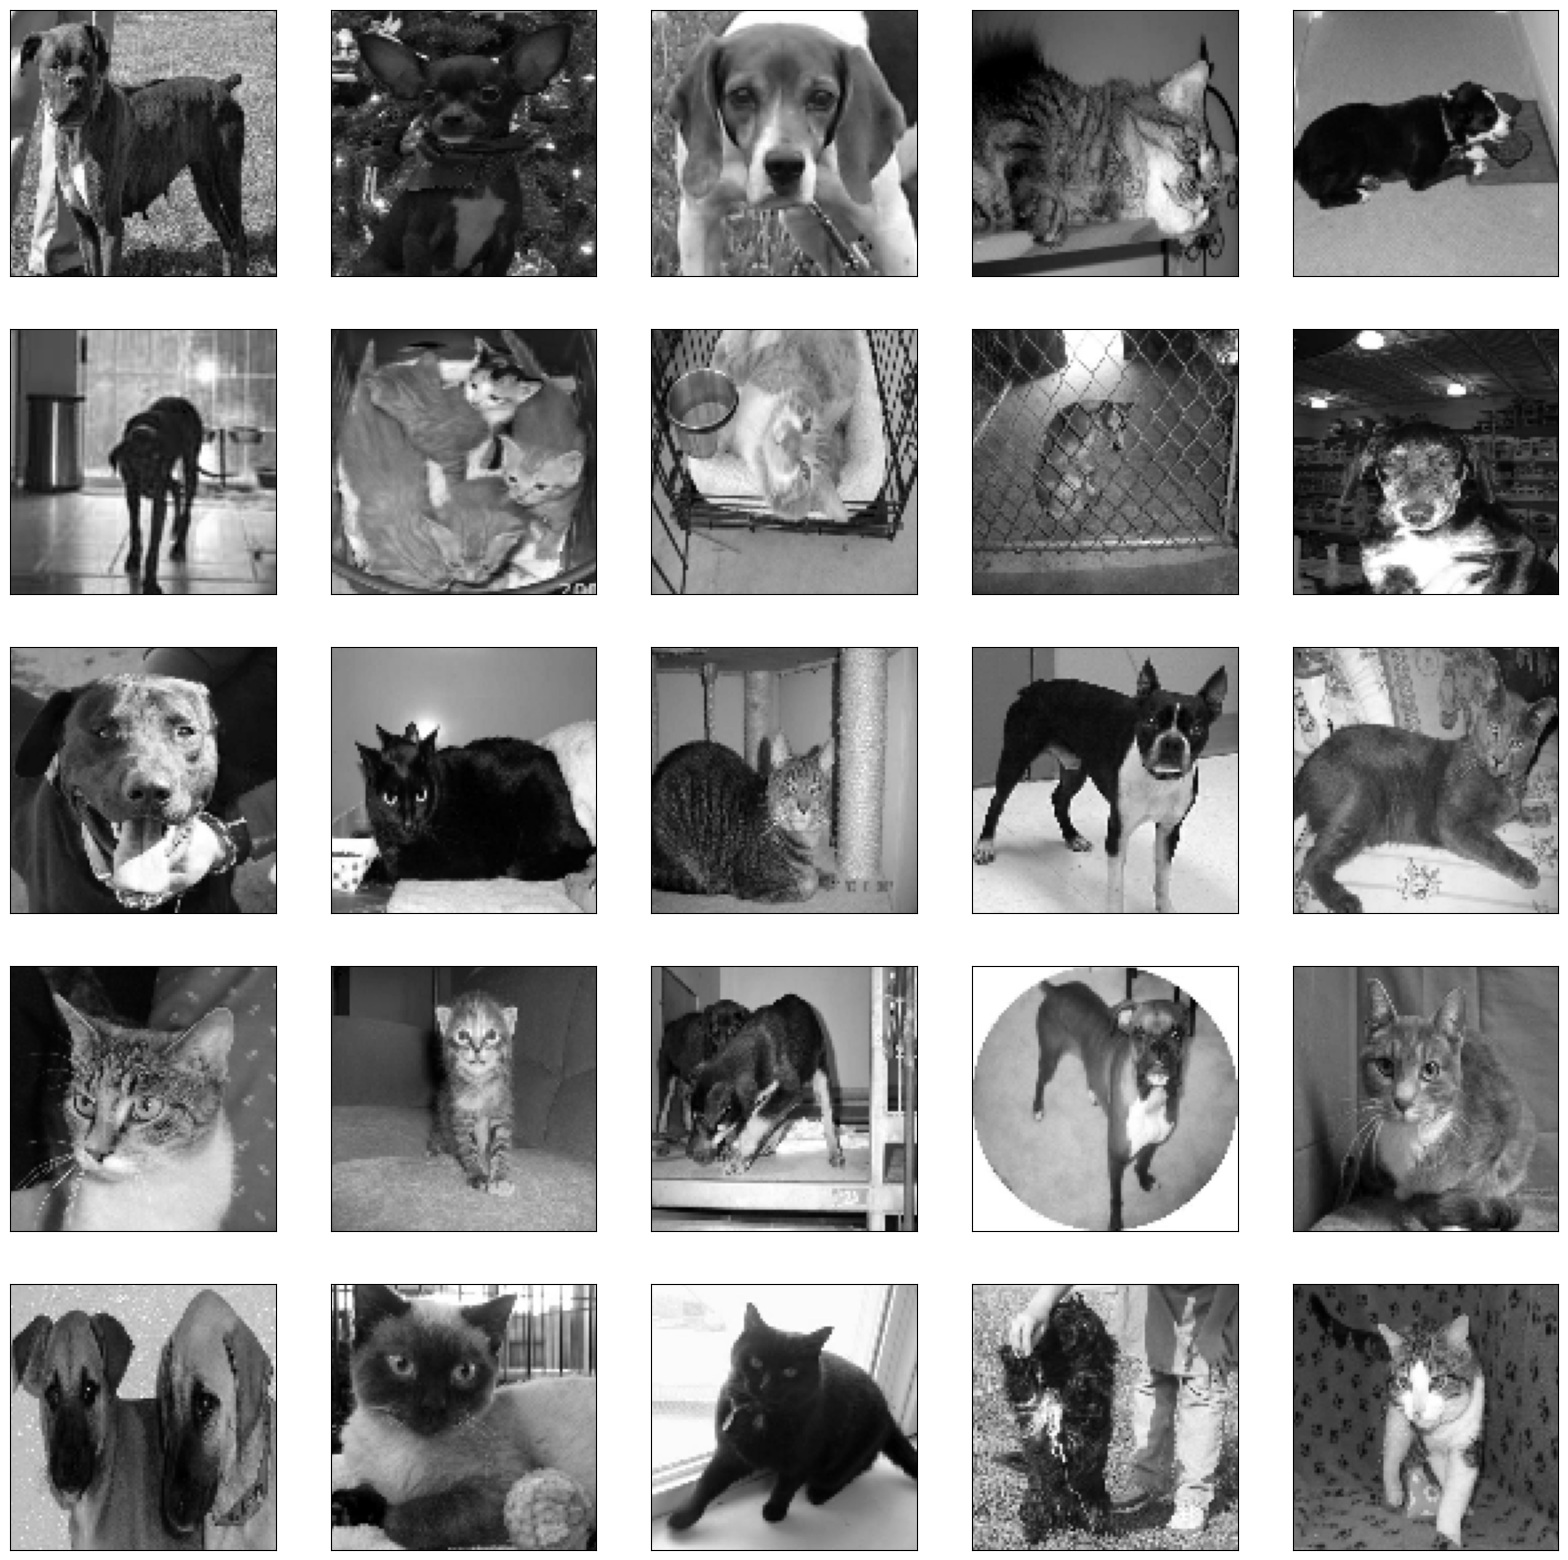

In [ ]:
# Datuak aldatu eta ikusi
# Irudien dimentsioak (100x100) eta koloreen eskala (zuri-beltza) aldatu
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(20,20))

IRUDIAREN_TAMAINA=100

for i, (irudia, etiketa) in enumerate(datuak['train'].take(25)):
  irudia = cv2.resize(irudia.numpy(), (IRUDIAREN_TAMAINA, IRUDIAREN_TAMAINA))
  irudia = cv2.cvtColor(irudia, cv2.COLOR_BGR2GRAY)
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(irudia, cmap='gray')

In [ ]:
# Datu guztien bikote eraldatuak izango dituen aldagaia (irudiak eta etiketak)
datuak_entrenamendua = []

In [ ]:
for i, (irudia, etiketa) in enumerate(datuak['train']): # Datu guztiak
  irudia = cv2.resize(irudia.numpy(), (IRUDIAREN_TAMAINA, IRUDIAREN_TAMAINA))
  irudia = cv2.cvtColor(irudia, cv2.COLOR_BGR2GRAY)
  irudia = irudia.reshape(IRUDIAREN_TAMAINA, IRUDIAREN_TAMAINA, 1) # 100,100,1ra aldatu tamaina
  datuak_entrenamendua.append([irudia, etiketa])

In [ ]:
# Aldagaiak dituen datu kopurua aztertu
len(datuak_entrenamendua)

23262

In [ ]:
# Aldagaiak prestatu X (sarrerak) eta y (etiketak) banatutak

X = [] #Sarreren irudiak (pixelak)
y = [] #Etiketak (txakurra edo katua)

for irudia, etiketa in datuak_entrenamendua:
  X.append(irudia)
  y.append(etiketa)

In [ ]:
X

In [ ]:
# X-en (Irudiak) datuak normalizatu. Hamartarrera bihurtu eta 255 zatitu 0-1 geratzeko eta ez 0-255
import numpy as np

X = np.array(X).astype(float) / 255

In [ ]:
# Etiketak moldatu
y = np.array(y)

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
# Tensorboard extentsioa kargatu
%load_ext tensorboard

In [ ]:
# Tensorboard hasi eta "logs" karpeta begiratzea agindu
%tensorboard --logdir logs

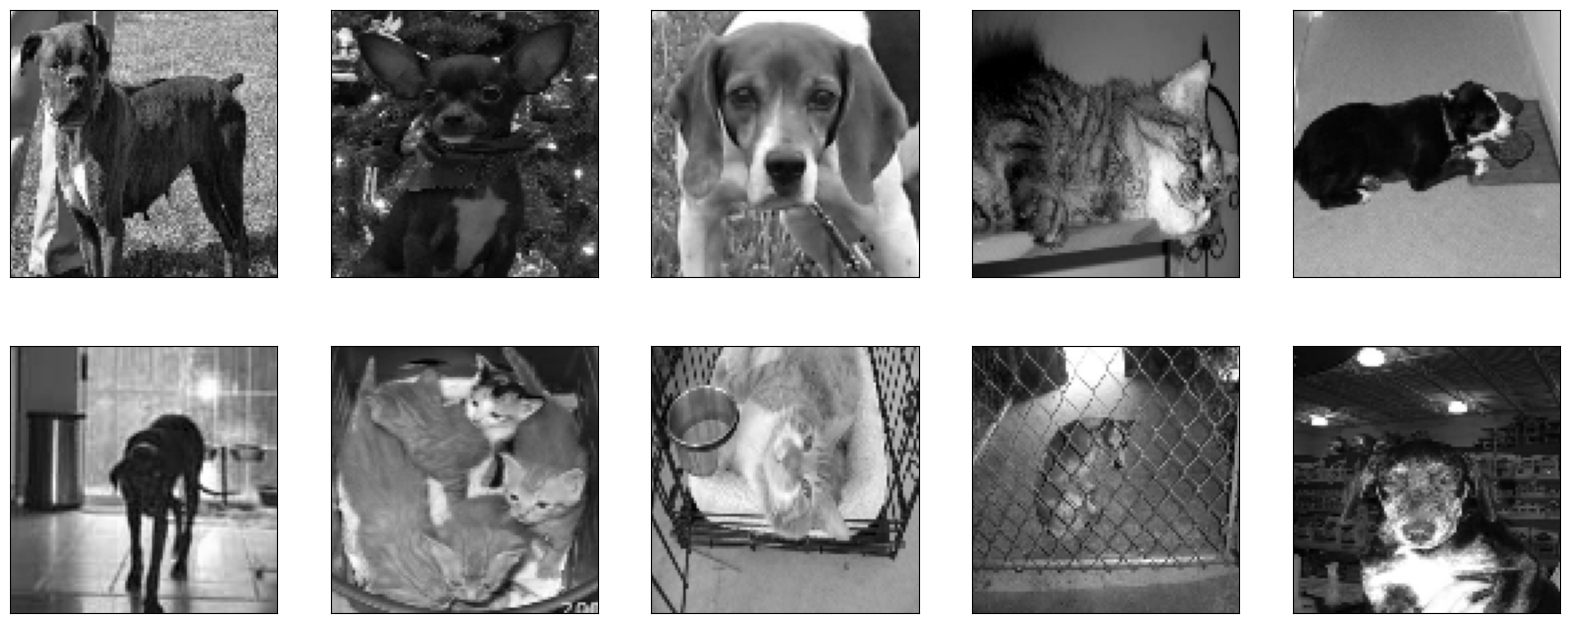

In [ ]:
# X-ren irudiak ikusi aldaketarik gabe
plt.figure(figsize=(20, 8))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X[i].reshape(100, 100), cmap="gray")

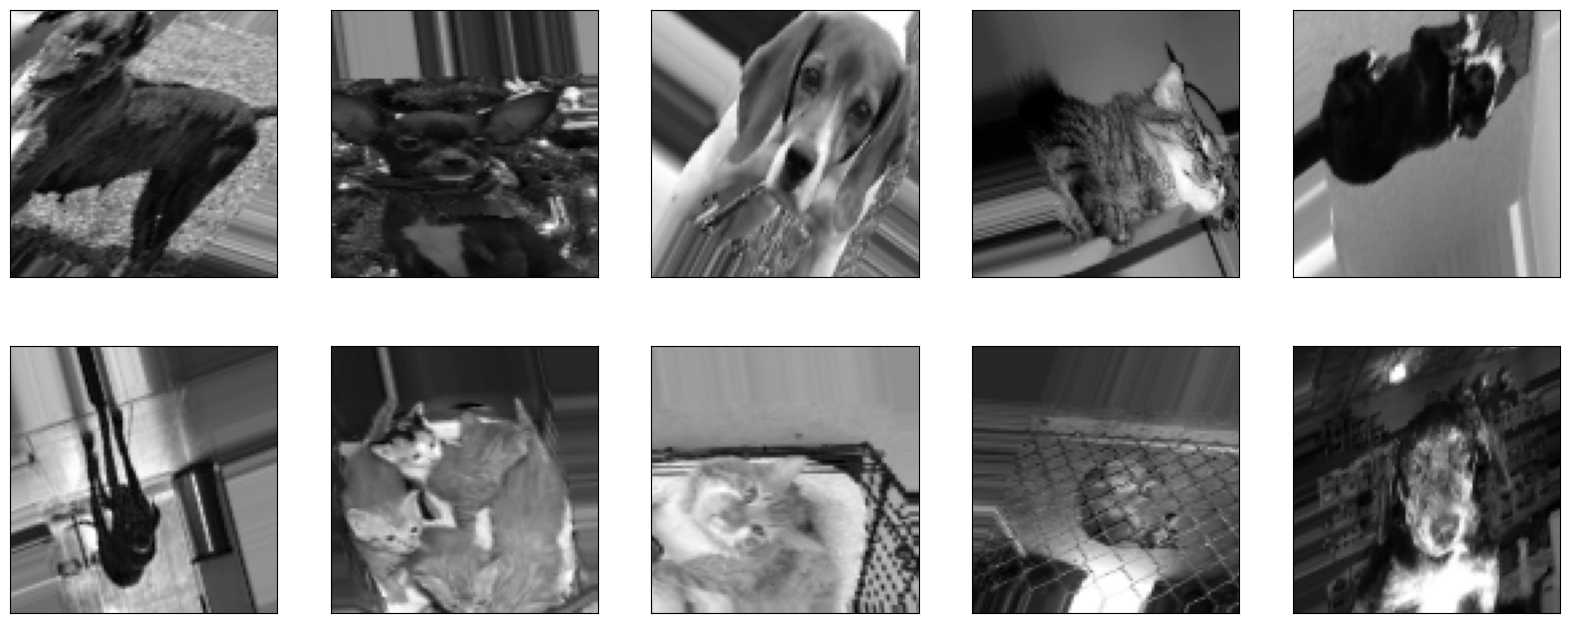

In [ ]:
# Datuen handipena egin irudiei eraldakateak aplikatzen eta emaitzaren 10 erakutsi
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=[0.7, 1.4],
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X)

plt.figure(figsize=(20,8))

for irudia, etiketa in datagen.flow(X, y, batch_size=10, shuffle=False):
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(irudia[i].reshape(100, 100), cmap="gray")
  break

In [ ]:
ereduSNK = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
ereduSNK.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [ ]:
# Entrenamendu eta frogen datuak banatu

len(X) * .85 #19700
len(X) - 19700 #3562

X_entrenamendua = X[:19700]
X_froga = X[19700:]

y_entrenamendua = y[:19700]
y_froga = y[19700:]

In [ ]:
# flow funtzioa erabili modeloaren FIT funtziora bidali ahal izateko iteratzaile gisa
data_gen_entrenamendua = datagen.flow(X_entrenamendua, y_entrenamendua, batch_size=32)

In [ ]:
tensorboardCNN_AD = TensorBoard(log_dir='logs-new/snk')

ereduSNK.fit(
    data_gen_entrenamendua,
    epochs=150, batch_size=32,
    validation_data=(X_froga, y_froga),
    steps_per_epoch=int(np.ceil(len(X_entrenamendua) / float(32))),
    validation_steps=int(np.ceil(len(X_froga) / float(32))),
    callbacks=[tensorboardCNN_AD]
)

Epoch 1/150
616/616 [==============================] - 30s 42ms/step - loss: 0.6840 - accuracy: 0.5519 - val_loss: 0.6653 - val_accuracy: 0.6016
Epoch 2/150
616/616 [==============================] - 25s 41ms/step - loss: 0.6627 - accuracy: 0.6007 - val_loss: 0.6508 - val_accuracy: 0.6168
Epoch 3/150
616/616 [==============================] - 26s 42ms/step - loss: 0.6488 - accuracy: 0.6215 - val_loss: 0.6414 - val_accuracy: 0.6235
Epoch 4/150
616/616 [==============================] - 25s 40ms/step - loss: 0.6326 - accuracy: 0.6466 - val_loss: 0.5985 - val_accuracy: 0.6878
Epoch 5/150
616/616 [==============================] - 25s 40ms/step - loss: 0.6202 - accuracy: 0.6592 - val_loss: 0.5929 - val_accuracy: 0.6873
Epoch 6/150
616/616 [==============================] - 25s 40ms/step - loss: 0.6138 - accuracy: 0.6643 - val_loss: 0.5730 - val_accuracy: 0.7086
Epoch 7/150
616/616 [==============================] - 27s 44ms/step - loss: 0.6002 - accuracy: 0.6776 - val_loss: 0.5695 - val_ac

In [ ]:
ereduSNK_AD.save('txakurrak-katuak-snk.h5')

In [ ]:
!pip install tensorflowjs

In [ ]:
!mkdir irteerako_karpeta

In [ ]:
!tensorflowjs_converter --input_format keras txakurrak-katuak-snk.h5 irteerako_karpeta